In [1]:
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# From Hugging Face
from transformers import (
    PreTrainedModel,
    PretrainedConfig,
    DataCollatorForLanguageModeling,
    AutoTokenizer,
    GPT2LMHeadModel,
    GPT2Config
)
from datasets import load_dataset

import time
import os
import psutil

In [3]:
# -------------------------------------------
# 1. Configuration for the GPT-Performer Model
# -------------------------------------------

class GPTPerformerConfig(PretrainedConfig):
    model_type = "gpt-performer"

    def __init__(
        self,
        vocab_size=50257,
        max_position_embeddings=1024,
        n_embd=256,
        n_layer=4,
        n_head=4,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
        # Performer-related
        performer_nb_features=64,  # Number of random features
        performer_generalized_attention=False,
        performer_kernel_type="relu",  # "relu" or "softmax"
        **kwargs
    ):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.max_position_embeddings = max_position_embeddings
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.hidden_dropout_prob = hidden_dropout_prob
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.performer_nb_features = performer_nb_features
        self.performer_generalized_attention = performer_generalized_attention
        self.performer_kernel_type = performer_kernel_type

In [4]:
# -------------------------------------------
# 2. Implement the Performer Attention
# -------------------------------------------

class PerformerAttention(nn.Module):
    """
    "Rethinking Attention with Performers" (Choromanski et al.)
    https://arxiv.org/abs/2009.14794
    """

    def __init__(
        self,
        embed_dim,
        num_heads,
        nb_features=64,
        dropout=0.1,
        kernel_type="relu",
        generalized_attention=False,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.nb_features = nb_features
        self.dropout = nn.Dropout(dropout)
        self.head_dim = embed_dim // num_heads

        # Q, K, V linear projections
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)

        self.kernel_type = kernel_type
        self.generalized_attention = generalized_attention

        # Random projection matrix for Performer
        self.random_features = nn.Parameter(
            torch.randn(self.num_heads, self.head_dim, self.nb_features),
            requires_grad=False
        )

        # Suggested scaling factor
        self.feature_scaling = 1.0 / math.sqrt(self.head_dim)

    def _kernel_projection(self, x: torch.Tensor) -> torch.Tensor:
        """
        Perform the random feature mapping.
        """
        # x shape: [batch_size, seq_len, num_heads, head_dim]
        x_expanded = x.unsqueeze(-2)  # [B, S, H, 1, D]

        # random_features shape: [num_heads, head_dim, nb_features] -> unsqueeze -> [1, 1, H, D, F]
        random_features_for_all_heads = self.random_features.unsqueeze(0).unsqueeze(0)

        # Matrix multiply
        result = torch.matmul(x_expanded, random_features_for_all_heads)  # [B, S, H, 1, F]
        result = result.squeeze(-2)  # => [B, S, H, F]

        # Apply scaling
        result = result * self.feature_scaling

        if self.generalized_attention and self.kernel_type == "softmax":
            # Approx RBF kernel with cos/sin expansions
            cos_proj = torch.cos(result)
            sin_proj = torch.sin(result)
            result = torch.cat([cos_proj, sin_proj], dim=-1)  # [B, S, H, 2*F]
        elif self.kernel_type == "relu":
            result = F.relu(result)

        return result

    def forward(self, hidden_states, attention_mask=None):
        """
        hidden_states: (batch_size, seq_len, embed_dim)
        attention_mask: (batch_size, 1, 1, seq_len) or None
        """
        batch_size, seq_len, _ = hidden_states.size()

        # Project Q, K, V
        q = self.query(hidden_states)  # [B, S, E]
        k = self.key(hidden_states)
        v = self.value(hidden_states)

        # Reshape to multiple heads
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim)

        q = q * self.feature_scaling

        # Kernel feature mapping
        q_features = self._kernel_projection(q)  # [B, S, H, F]
        k_features = self._kernel_projection(k)  # [B, S, H, F]

        # (Naive) attention approx: (Phi(q) (Phi(k)^T v))
        k_features_v = torch.einsum("bshf,bshd->bhfd", k_features, v)  # [B, H, F, D]
        attn_out = torch.einsum("bshf,bhfd->bshd", q_features, k_features_v)  # [B, S, H, D]

        attn_out = attn_out / math.sqrt(self.head_dim)

        # Merge heads
        attn_out = attn_out.permute(0, 2, 1, 3).contiguous()  # [B, H, S, D]
        attn_out = attn_out.view(batch_size, seq_len, self.embed_dim)

        # Final linear + dropout
        attn_out = self.out(attn_out)
        attn_out = self.dropout(attn_out)

        return attn_out

In [5]:
# -------------------------------------------
# 3. Define a GPT-Performer Block
# -------------------------------------------

class GPTPerformerBlock(nn.Module):
    """
    Single Transformer block that uses Performer attention instead of standard attention.
    """

    def __init__(self, config: GPTPerformerConfig):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd, eps=1e-5)
        self.attn = PerformerAttention(
            embed_dim=config.n_embd,
            num_heads=config.n_head,
            nb_features=config.performer_nb_features,
            dropout=config.attention_probs_dropout_prob,
            kernel_type=config.performer_kernel_type,
            generalized_attention=config.performer_generalized_attention,
        )
        self.ln_2 = nn.LayerNorm(config.n_embd, eps=1e-5)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.hidden_dropout_prob),
        )

    def forward(self, hidden_states, attention_mask=None):
        # Attention
        residual = hidden_states
        hidden_states = self.ln_1(hidden_states)
        hidden_states = self.attn(hidden_states, attention_mask=attention_mask)
        hidden_states = residual + hidden_states

        # MLP
        residual = hidden_states
        hidden_states = self.ln_2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states

        return hidden_states

In [6]:
# -------------------------------------------
# 4. Build the Complete GPT-Performer Model
# -------------------------------------------

class GPTPerformerModel(PreTrainedModel):
    """
    A GPT-style language model using Performer attention.
    """

    config_class = GPTPerformerConfig

    def __init__(self, config: GPTPerformerConfig):
        super().__init__(config)
        self.embed_dim = config.n_embd

        # Embeddings
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)  # token embeddings
        self.wpe = nn.Embedding(config.max_position_embeddings, config.n_embd)  # positional embeddings
        self.drop = nn.Dropout(config.hidden_dropout_prob)

        # Blocks
        self.blocks = nn.ModuleList([GPTPerformerBlock(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd, eps=1e-5)

        # LM head
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.post_init()  # from PreTrainedModel

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None,
        **kwargs
    ):
        """
        input_ids: [batch_size, seq_len]
        attention_mask: [batch_size, seq_len]
        labels: optional, [batch_size, seq_len]
        """
        batch_size, seq_len = input_ids.shape
        device = input_ids.device

        position_ids = torch.arange(0, seq_len, dtype=torch.long, device=device)
        position_ids = position_ids.unsqueeze(0).expand(batch_size, seq_len)

        # Embed
        inputs_embeds = self.wte(input_ids)
        position_embeds = self.wpe(position_ids)
        hidden_states = inputs_embeds + position_embeds
        hidden_states = self.drop(hidden_states)

        # Extended attention mask if we want to incorporate pad tokens, etc.
        extended_mask = None
        if attention_mask is not None:
            extended_mask = attention_mask.unsqueeze(1).unsqueeze(2)  # [B, 1, 1, S]
            extended_mask = (1.0 - extended_mask) * -1e4

        # Pass through blocks
        for block in self.blocks:
            hidden_states = block(hidden_states, attention_mask=extended_mask)

        # Final layer norm
        hidden_states = self.ln_f(hidden_states)

        # LM head
        logits = self.lm_head(hidden_states)

        loss = None
        if labels is not None:
            # Shift for next-token prediction
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1)
            )

        return {"loss": loss, "logits": logits}

In [7]:
# -------------------------------------------
# 5. Data Loading: WikiText
# -------------------------------------------

def load_wikitext_dataset(dataset_name="wikitext", dataset_version="wikitext-2-raw-v1"):
    # Returns a DatasetDict with 'train', 'validation', 'test' splits.
    dataset = load_dataset(dataset_name, dataset_version)
    return dataset

# -------------------------------------------
# 6. Tokenizer
# -------------------------------------------

def get_tokenizer(model_name="gpt2"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # GPT-2 doesn't have an official pad token
    tokenizer.pad_token = tokenizer.eos_token
    return tokenizer

In [8]:
# -------------------------------------------
# 7. Dataset Preprocessing
# -------------------------------------------

def preprocess_examples(examples, tokenizer, block_size=128):
    """
    Tokenize the text examples, chunk them into blocks of size 'block_size'.
    Returns a dict of tokenized examples (input_ids, etc.).
    """
    text = examples["text"]
    encoding = tokenizer(
        text,
        add_special_tokens=False,
        truncation=True,
        max_length=block_size,
        return_attention_mask=False
    )
    return encoding

def group_texts(examples, block_size=128):
    """
    Group the list of token ids into continuous chunks of size block_size.
    """
    concatenated = []
    for ids in examples["input_ids"]:
        concatenated.extend(ids)
    result = []
    for i in range(0, len(concatenated), block_size):
        chunk = concatenated[i : i + block_size]
        if len(chunk) == block_size:
            result.append(chunk)
    return {"input_ids": result}

In [9]:
class UsageTracker:
    def __init__(self):
        self.start_time = None
        self.start_cpu_time = None
        self.train_stats = {
            "epoch": [], "step": [],
            "wall_time_s": [], "cpu_time_s": [],
            "cpu_mem_mb": [], "gpu_alloc_mb": [], "gpu_reserved_mb": []
        }
        self.infer_stats = {
            "max_token_length": [],
            "wall_time_s": [], "cpu_time_s": [],
            "cpu_mem_mb": [], "gpu_alloc_mb": [], "gpu_reserved_mb": []
        }

    def start_tracking(self):
        self.start_time = time.time()
        self.start_cpu_time = time.process_time()

    def stop_tracking(self, is_training, epoch=None, step=None, max_token_length=None):
        if self.start_time is None or self.start_cpu_time is None:
            raise ValueError("Tracking not started. Call start_tracking() first.")

        end_time = time.time()
        end_cpu_time = time.process_time()

        proc = psutil.Process(os.getpid())
        cpu_mem = proc.memory_info().rss / (1024**2)
        if torch.cuda.is_available():
            gpu_alloc    = torch.cuda.memory_allocated(device) / (1024**2)
            gpu_reserved = torch.cuda.memory_reserved(device) / (1024**2)
        else:
            gpu_alloc = gpu_reserved = 0.0

        obj = self.train_stats if is_training else self.infer_stats
        obj["wall_time_s"].append(end_time - self.start_time)
        obj["cpu_time_s"].append(end_cpu_time - self.start_cpu_time)
        obj["cpu_mem_mb"].append(cpu_mem)
        obj["gpu_alloc_mb"].append(gpu_alloc)
        obj["gpu_reserved_mb"].append(gpu_reserved)
        if is_training:
            obj["epoch"].append(epoch + 1)
            obj["step"].append(step + 1)
        else:
            obj["max_token_length"].append(max_token_length)

        self.start_time = None
        self.start_cpu_time = None

    def plot(self):
        df_train = pd.DataFrame(self.train_stats)
        df_inf   = pd.DataFrame(self.infer_stats)

        # --- Training plots (line plots vs. step) ---
        for metric in ["wall_time_s", "cpu_time_s", "cpu_mem_mb", "gpu_alloc_mb", "gpu_reserved_mb"]:
            plt.figure(figsize=(8, 4))
            plt.plot(df_train["step"], df_train[metric])
            plt.xlabel("Training Step")
            plt.ylabel(metric.replace("_", " ").title())
            plt.title(f"{metric.replace('_', ' ').title()} During Training")
            plt.show()

        # # --- Inference plots (bar plots vs. call index) ---
        # for metric in ["wall_time_s", "cpu_time_s", "cpu_mem_mb", "gpu_alloc_mb", "gpu_reserved_mb"]:
        #     plt.figure(figsize=(8, 4))
        #     plt.bar(range(len(df_inf)), df_inf[metric])
        #     plt.xlabel("Inference Call #")
        #     plt.ylabel(metric.replace("_", " ").title())
        #     plt.title(f"{metric.replace('_', ' ').title()} Per Inference")
        #     plt.show()

        prompt_lengths = self.infer_stats["max_token_length"]

        # --- Inference plots (bar plots vs. token length) ---
        for metric in ["wall_time_s", "cpu_time_s", "cpu_mem_mb", "gpu_alloc_mb", "gpu_reserved_mb"]:
            plt.figure(figsize=(8, 4))
            plt.scatter(prompt_lengths, self.infer_stats[metric])
            plt.xlabel("Prompt Token Length")
            plt.ylabel(metric.replace("_", " ").title())
            plt.title(f"{metric.replace('_', ' ').title()} vs. Prompt Length")
            plt.show()

In [10]:
# -------------------------------------------
# 8. Training
# -------------------------------------------

# 1) Load dataset
raw_dataset = load_wikitext_dataset()

# 2) Tokenizer
tokenizer = get_tokenizer()

# 3) Preprocess dataset
block_size = 128
def tokenize_function(examples):
    return preprocess_examples(examples, tokenizer, block_size=block_size)
tokenized_dataset = raw_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# 4) Group texts
def group_function(examples):
    return group_texts(examples, block_size=block_size)
lm_dataset = tokenized_dataset.map(group_function, batched=True)

# 5) Data collator for LM
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [11]:
# 6) Create PyTorch Datasets & DataLoaders
train_dataset = lm_dataset["train"]
val_dataset = lm_dataset["validation"]

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=data_collator)

# 7) Initialize model and optimizer
# Teacher model (original GPT-2)
teacher_model = GPT2LMHeadModel.from_pretrained("gpt2")

# Student model (GPT-Performer)
config = GPTPerformerConfig(
    vocab_size=len(tokenizer),
    max_position_embeddings=1024,
    n_embd=768,  # Match GPT-2 small embedding dimension
    n_layer=12,  # Match GPT-2 small number of layers
    n_head=12,   # Match GPT-2 small number of heads
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    performer_nb_features=256,
    performer_generalized_attention=True,
    performer_kernel_type="softmax",  # Use softmax kernel to match original attention
)
performer_model = GPTPerformerModel(config)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# 8) Training loop

train_loss_vals = []
val_loss_vals = []
tracker = UsageTracker()

def train(performer_model, teacher_model, train_dataloader, val_dataloader, num_epochs=50,
                               device="cuda", temperature=0.7, learning_rate=1e-3):
    """
    Train the performer model with KL divergence loss between performer and GPT-2 logits

    Args:
        performer_model: GPTPerformerModel instance
        teacher_model: Original GPT2LMHeadModel instance (frozen)
        train_dataloader: Training data loader
        val_dataloader: Validation data loader
        num_epochs: Number of training epochs
        device: Training device
        temperature: Temperature for softening the logits
    """
    performer_model.to(device)
    teacher_model.to(device)

    for param in teacher_model.parameters():
        param.requires_grad = False

    optimizer = torch.optim.AdamW(performer_model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs) # change scheduler, LR, context window, etc.

    for epoch in range(num_epochs):
        performer_model.train()
        teacher_model.eval()  # Always in eval mode

        total_loss = 0.0

        for step, batch in enumerate(train_dataloader):
            tracker.start_tracking()
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device) if "labels" in batch else None
            attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)

            performer_outputs = performer_model(input_ids=input_ids,
                                              attention_mask=attention_mask,
                                              labels=labels)
            performer_logits = performer_outputs["logits"]

            with torch.no_grad():
                teacher_outputs = teacher_model(input_ids=input_ids,
                                              attention_mask=attention_mask,
                                              labels=labels)
                teacher_logits = teacher_outputs.logits

            # Calculate loss
            # Apply temperature to soften logits
            teacher_logits_t = teacher_logits / temperature
            performer_logits_t = performer_logits / temperature

            # KL divergence
            loss_kl = nn.KLDivLoss(reduction="sum")(
                F.log_softmax(performer_logits / temperature, dim=-1),
                F.softmax(teacher_logits   / temperature, dim=-1)
            )
            loss = loss_kl / attention_mask.sum() * (temperature * temperature)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track losses
            loss_val = loss.item()
            total_loss += loss_val

            tracker.stop_tracking(is_training=True, epoch=epoch, step=step)

            if (step + 1) % 100 == 0:
                print(f"Epoch {epoch+1} Step {step+1} -  Loss: {loss_val:.4f}")

        scheduler.step()

        # Calculate average loss
        avg_train_loss = total_loss / len(train_dataloader)
        train_loss_vals.append(avg_train_loss)
        print(f"Epoch {epoch+1} Training - Loss: {avg_train_loss:.4f}")

        # 9) Validation loop
        performer_model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)

                # Get logits from both models
                performer_outputs = performer_model(input_ids=input_ids, attention_mask=attention_mask)
                performer_logits = performer_outputs["logits"]

                teacher_outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask)
                teacher_logits = teacher_outputs.logits

                # KL divergence for validation
                val_loss_kl = nn.KLDivLoss(reduction="sum")(
                    F.log_softmax(performer_logits / temperature, dim=-1),
                    F.softmax(teacher_logits   / temperature, dim=-1)
                )
                val_loss = loss_kl / attention_mask.sum() * (temperature * temperature)

                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_loss_vals.append(avg_val_loss)
        print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}")

    return train_loss_vals, val_loss_vals

# Train with KL distillation
train_losses, val_losses = train(
    performer_model=performer_model,
    teacher_model=teacher_model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=10,
    device=device
)

# Save the trained performer model
performer_model.save_pretrained("gpt-performer-distilled")
tokenizer.save_pretrained("gpt-performer-distilled")

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1 Step 100 -  Loss: 2.3319
Epoch 1 Step 200 -  Loss: 2.2764
Epoch 1 Step 300 -  Loss: 2.3747
Epoch 1 Step 400 -  Loss: 2.6358
Epoch 1 Step 500 -  Loss: 2.2959
Epoch 1 Step 600 -  Loss: 2.2830
Epoch 1 Step 700 -  Loss: 2.5586
Epoch 1 Step 800 -  Loss: 2.1597
Epoch 1 Step 900 -  Loss: 2.4169
Epoch 1 Step 1000 -  Loss: 2.5322
Epoch 1 Step 1100 -  Loss: 2.1825
Epoch 1 Step 1200 -  Loss: 2.3899
Epoch 1 Step 1300 -  Loss: 2.3812
Epoch 1 Step 1400 -  Loss: 2.1861
Epoch 1 Step 1500 -  Loss: 2.4136
Epoch 1 Step 1600 -  Loss: 2.1816
Epoch 1 Step 1700 -  Loss: 2.1751
Epoch 1 Step 1800 -  Loss: 2.0733
Epoch 1 Step 1900 -  Loss: 2.3318
Epoch 1 Step 2000 -  Loss: 2.2472
Epoch 1 Step 2100 -  Loss: 2.2974
Epoch 1 Step 2200 -  Loss: 2.2545
Epoch 1 Step 2300 -  Loss: 2.1787
Epoch 1 Step 2400 -  Loss: 2.3042
Epoch 1 Step 2500 -  Loss: 2.3611
Epoch 1 Step 2600 -  Loss: 2.1759
Epoch 1 Step 2700 -  Loss: 2.3240
Epoch 1 Step 2800 -  Loss: 2.3254
Epoch 1 Step 2900 -  Loss: 2.3526
Epoch 1 Step 3000 -  Lo

KeyboardInterrupt: 

In [12]:
import os
from google.colab import drive
drive.mount('/content/drive')

CHECKPOINT_DIR = '/content/drive/MyDrive/'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

checkpoint = {
    'epoch': 6, # next epoch to start from
    'model_state_dict': performer_model.state_dict(),
    # 'optimizer_state_dict': optimizer.state_dict(),
    'loss_vals': train_loss_vals,
    'val_loss_vals': val_loss_vals
}
torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, f'ckpt_epoch_6.pth'))
print(f"Saved checkpoint for epoch 6")

KeyboardInterrupt: 

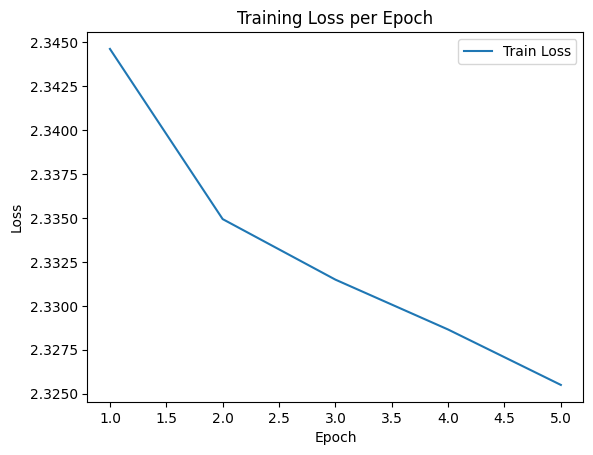

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_loss_vals) + 1))

# Plot training loss
plt.plot(epochs, train_loss_vals, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.show()

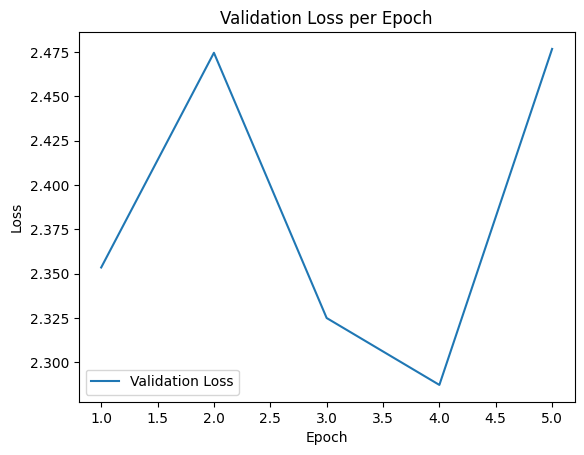

In [ ]:
epochs = list(range(1, len(val_loss_vals) + 1))

plt.plot(epochs, val_loss_vals, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss per Epoch")
plt.legend()
plt.show()

In [16]:
import os
from google.colab import drive
drive.mount('/content/drive')

tracker = UsageTracker()

CHECKPOINT_PATH = '/content/drive/MyDrive/ckpt_epoch_6.pth'

checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
performer_model.load_state_dict(checkpoint['model_state_dict'])

import torch
import torch.nn.functional as F

sample_prompts = [
    "Hello, my name is",
    "The meaning of life is",
    "In a shocking turn of events,",
    "The future of artificial intelligence"
]

top_k = 10
max_new_tokens = 50

for prompt in sample_prompts:
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    performer_model.eval()

    tracker.start_tracking()

    with torch.no_grad():
        for _ in range(max_new_tokens):
            outputs = performer_model(inputs)
            logits = outputs["logits"]
            logits = logits[0, -1, :]  # Get logits for the last token

            # Top-k sampling
            top_k_logits, top_k_indices = torch.topk(logits, top_k)
            probs = F.softmax(top_k_logits, dim=-1)
            next_token_id = top_k_indices[torch.multinomial(probs, num_samples=1)]

            # Append new token to sequence
            next_token_id = next_token_id.view(1, 1)  # ensures shape [1, 1]
            inputs = torch.cat([inputs, next_token_id], dim=1)

    generated_text = tokenizer.decode(inputs[0])
    tracker.stop_tracking(is_training=False, max_token_length=max_new_tokens)

    print(f"Prompt: {prompt}")
    print(f"Generated text: {generated_text}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Prompt: Hello, my name is
Generated text: Hello, my name is the
 and. of the and and in , to in and of and , and the of of a and the
 the . the, of
 the a, the the , of the. and, the of. a the the the a of
Prompt: The meaning of life is
Generated text: The meaning of life is and in to, the of of the and the and the the. the the the , the the the,. the , the the the a and and the . , of the. a a the of the and of ,, of . to

Prompt: In a shocking turn of events,
Generated text: In a shocking turn of events,. the , the in of , of of,
 in the the, a a of of to and of the and a of . a to and the
. ,
 . to the , of the the. and of , the a to .
Prompt: The future of artificial intelligence
Generated text: The future of artificial intelligence of to , , and a a to. a
 and and the
 of the the of. a the , the, , ,

 and the and. a a
 of. and the. the and a of and of t

In [ ]:
sample_prompts = [
    "Hello, my name is",
    "The meaning of life is",
    "In a shocking turn of events,",
    "The future of artificial intelligence"
]

for prompt in sample_prompts:
  inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
  performer_model.eval()
  max_new_tokens = 50

  tracker.start_tracking()

  with torch.no_grad():
      for _ in range(max_new_tokens):
          outputs = performer_model(inputs)
          logits = outputs["logits"]
          # Take the last token's logits and greedily pick the argmax
          next_token_id = torch.argmax(logits[0, -1, :])
          # Append the new token to the current sequence (dimension 1 is the sequence)
          inputs = torch.cat([inputs, next_token_id.unsqueeze(0).unsqueeze(0)], dim=1)

  # Decode the entire generated sequence
  generated_text = tokenizer.decode(inputs[0])
  tracker.stop_tracking(is_training=False, max_token_length=max_new_tokens)
  print(f"Prompt: {prompt}")
  print(f"Generated text: {generated_text}")

Prompt: Hello, my name is
Generated text: Hello, my name is the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Prompt: The meaning of life is
Generated text: The meaning of life is the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Prompt: In a shocking turn of events,
Generated text: In a shocking turn of events, the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Prompt: The future of artificial intelligence
Generated text: The future of artificial intelligence the the the the the the the the the the the the the the the the the the the the the th

Custom Model Plots


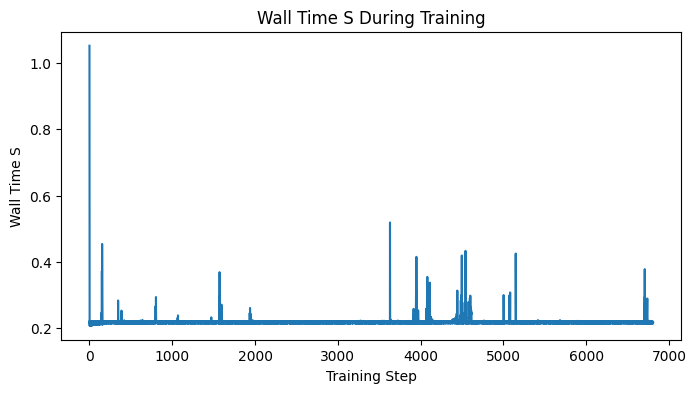

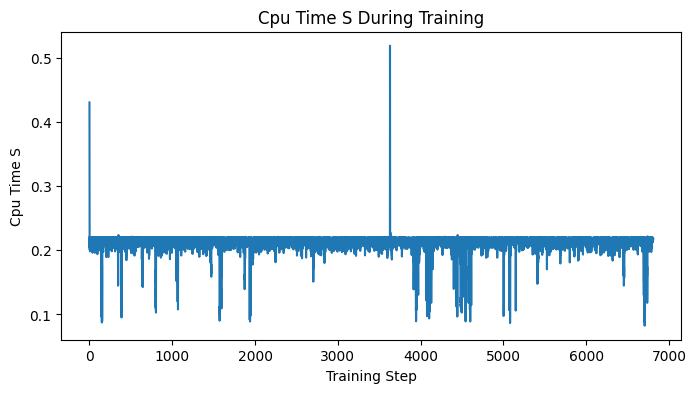

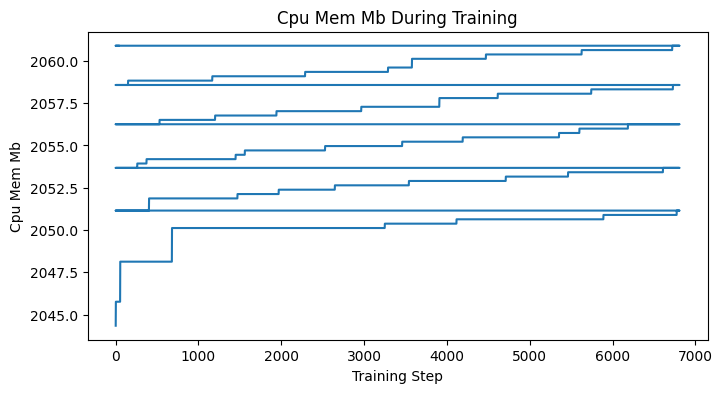

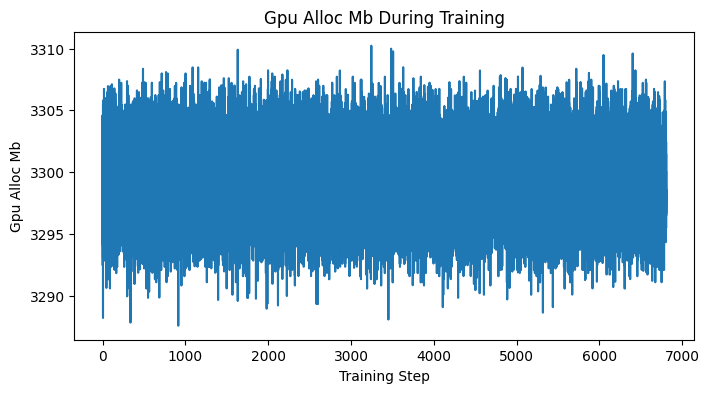

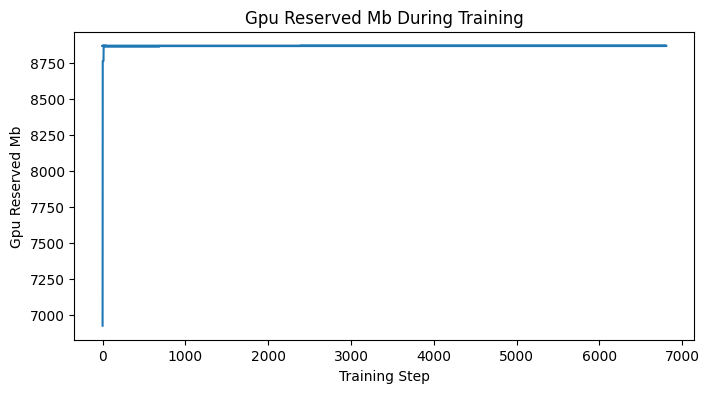

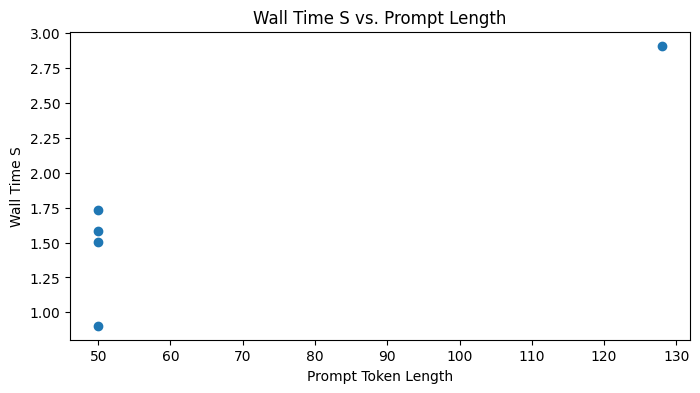

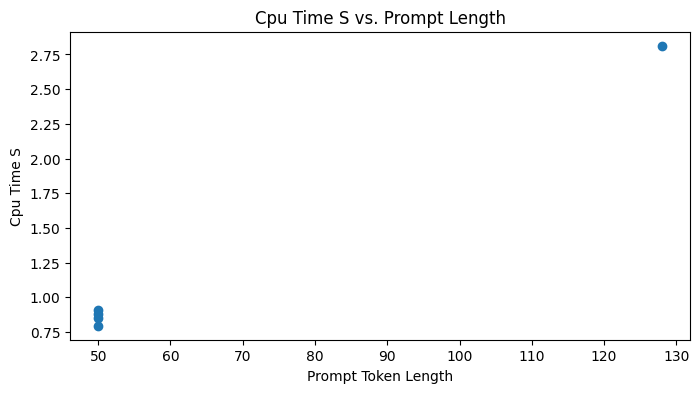

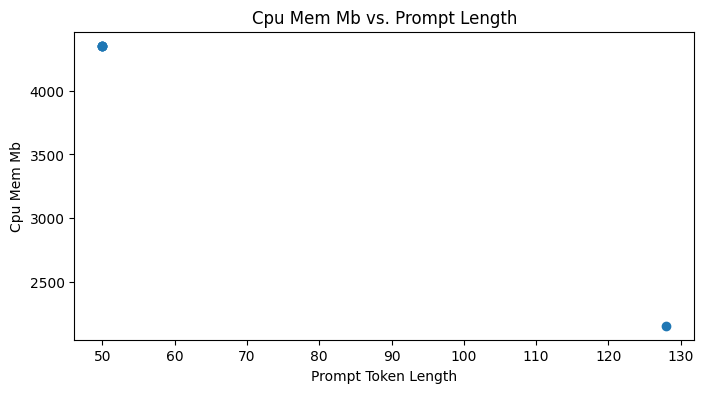

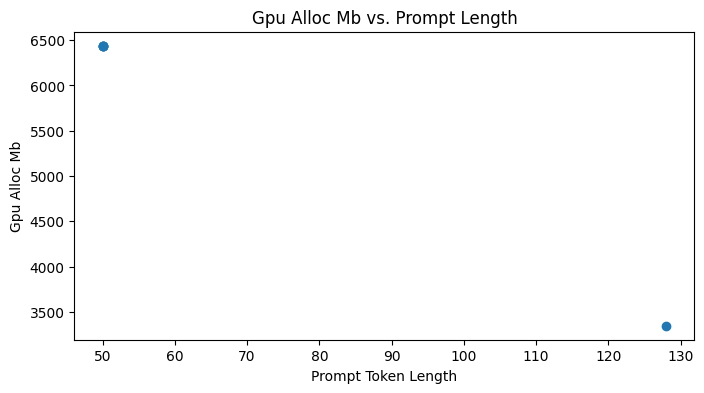

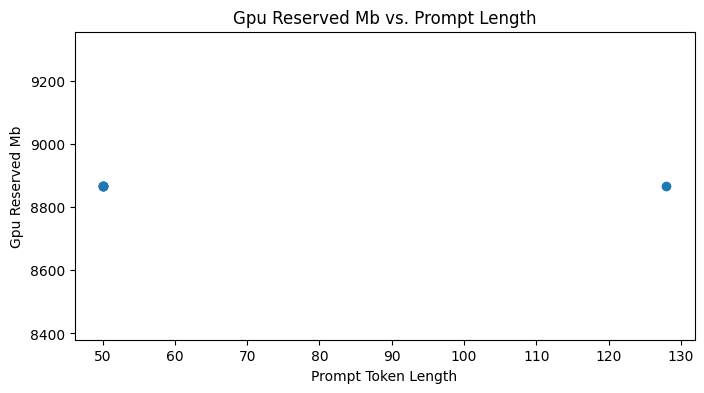

In [ ]:
import pandas as pd

# Plot usage
print("Custom Model Plots")
tracker.plot()